In [1]:
import os
import json
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

In [2]:
DATA_DIR = r"D:\Master of Computer Science\25S1 COMP5703 ITCP\Data\Dataset of MOANA-20250409T093924Z-001\Dataset of MOANA\single_island\X_band_label"
image_dir = DATA_DIR
label_dir = DATA_DIR

# lists
image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(".png")])
print(f"Total images: {len(image_files)}")

Total images: 1655


In [3]:
# An example with ground-truth boxes
def load_image_and_gt(fname):
    img_path  = os.path.join(image_dir, fname)
    json_path = img_path.replace('.png', '.json')
    img = np.array(Image.open(img_path).convert('L'))
    with open(json_path, 'r') as jf:
        data = json.load(jf)
    gt = [(ann['xmin'], ann['ymin'], ann['width'], ann['height'])
          for ann in data.get('annotations',[])]
    return img, gt

img0, gt0 = load_image_and_gt(image_files[0])
print(f"Example image shape: {img0.shape}, GT boxes: {len(gt0)}")

Example image shape: (2048, 2048), GT boxes: 2


In [4]:
# CA-CFAR implementation
def cfar_detect(image, T=10, G=2, Pfa=1e-3):
    
    img = image.astype(np.float32)
    N = (2*(T+G)+1)**2 - (2*G+1)**2
    alpha = N * ((1.0/Pfa)**(1.0/N) - 1.0)
    # Sum in total window
    total = cv2.boxFilter(img, -1, (2*(T+G)+1, 2*(T+G)+1),
                          borderType=cv2.BORDER_CONSTANT)
    # Sum in guard window (includes CUT)
    guard = cv2.boxFilter(img, -1, (2*G+1, 2*G+1),
                          borderType=cv2.BORDER_CONSTANT)
    noise = (total - guard) / float(N)
    thresh = noise * alpha
    det = (img > thresh).astype(np.uint8)
    # zero‐out borders
    det[:T+G,:] = 0; det[-(T+G):,:] = 0
    det[: ,:T+G] = 0; det[: ,-(T+G):] = 0
    return det

# Test on example
mask0 = cfar_detect(img0, T=10, G=2, Pfa=1e-2)
print(f"Detected pixels (example): {mask0.sum()}")

Detected pixels (example): 40137


In [5]:
# Connected components - bounding boxes
def detections_to_boxes(det_mask, min_area=5):
    
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(det_mask, 8)
    boxes = []
    for i in range(1, num_labels):
        x,y,w,h,area = stats[i]
        if area < min_area: continue
        boxes.append((x,y,w,h))
    return boxes

# Test on example
det_boxes0 = detections_to_boxes(mask0)
print(f"CFAR boxes (example): {len(det_boxes0)}")

CFAR boxes (example): 47


In [6]:
# IoU utility and evaluation loop
def compute_iou(a, b):
    xA = max(a[0], b[0]); yA = max(a[1], b[1])
    xB = min(a[0]+a[2], b[0]+b[2]); yB = min(a[1]+a[3], b[1]+b[3])
    if xB <= xA or yB <= yA: return 0.0
    inter = (xB-xA)*(yB-yA)
    union = a[2]*a[3] + b[2]*b[3] - inter
    return inter/union

# Evaluate all frames
TP=FP=FN=0
for fn in image_files:
    img, gt_boxes = load_image_and_gt(fn)
    det_mask = cfar_detect(img, T=10, G=2, Pfa=1e-2)
    det_boxes = detections_to_boxes(det_mask)

    matched = [False]*len(gt_boxes)
    # match detections - GT
    for db in det_boxes:
        found=False
        for i,gb in enumerate(gt_boxes):
            if not matched[i] and compute_iou(db, gb)>=0.5:
                matched[i]=True; TP+=1; found=True; break
        if not found:
            FP+=1
    FN += matched.count(False)

precision = TP/(TP+FP) if TP+FP>0 else 0
recall    = TP/(TP+FN) if TP+FN>0 else 0
print(f"Precision: {precision:.3f}, Recall: {recall:.3f} @ IoU=0.5")


Precision: 0.288, Recall: 0.949 @ IoU=0.5


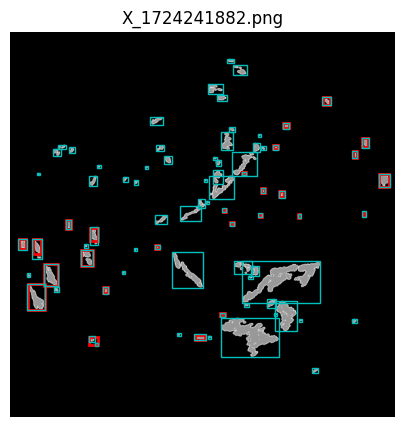

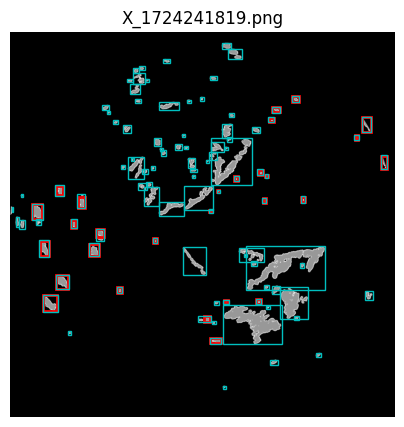

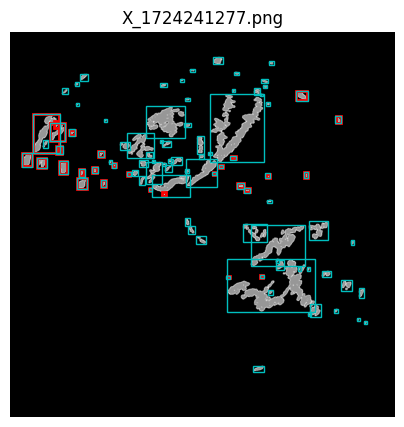

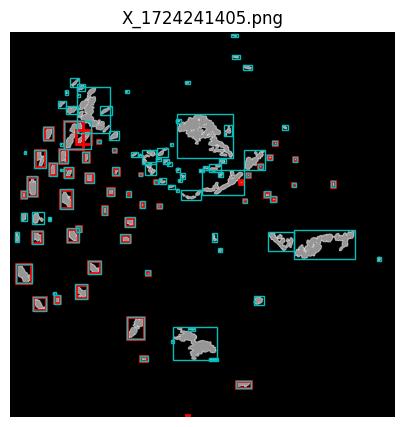

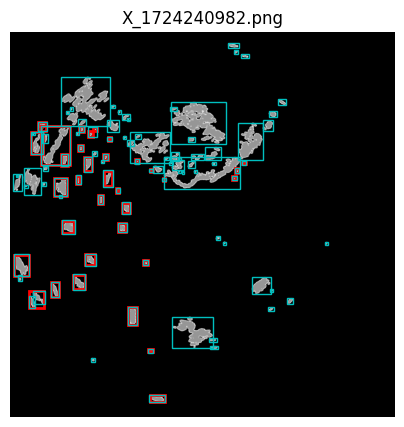

In [7]:
# Visualize 5 random samples
import random
samples = random.sample(image_files, 5)

def show_frame(fn):
    img, gt = load_image_and_gt(fn)
    det = cfar_detect(img, T=10, G=2, Pfa=1e-2)
    boxes_det = detections_to_boxes(det)
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(img, cmap='gray')
    # GT
    for x,y,w,h in gt:
        ax.add_patch(patches.Rectangle((x,y),w,h,edgecolor='r',facecolor='none',linewidth=2))
    # CFAR
    for x,y,w,h in boxes_det:
        ax.add_patch(patches.Rectangle((x,y),w,h,edgecolor='c',facecolor='none',linewidth=1))
    ax.set_title(fn); ax.axis('off')
    plt.show()

for fn in samples:
    show_frame(fn)


In [8]:
# Average Precision, Recall, F1-score
precisions = []
recalls = []
f1s = []

for fn in image_files:
    # Load GT and detections
    img, gt_boxes = load_image_and_gt(fn)
    det_mask = cfar_detect(img, T=10, G=2, Pfa=1e-2)
    det_boxes = detections_to_boxes(det_mask)

    # Match detections - GT
    matched = [False] * len(gt_boxes)
    TP_i = 0
    for db in det_boxes:
        hit = False
        for i, gb in enumerate(gt_boxes):
            if not matched[i] and compute_iou(db, gb) >= 0.5:
                matched[i] = True
                TP_i += 1
                hit = True
                break
    
    FP_i = len(det_boxes) - TP_i
    FN_i = len(gt_boxes) - TP_i

    # Image precision & recall
    prec_i = TP_i / (TP_i + FP_i) if (TP_i + FP_i) > 0 else 0.0
    rec_i  = TP_i / (TP_i + FN_i) if (TP_i + FN_i) > 0 else 0.0
    # F1‐score
    f1_i   = 2 * prec_i * rec_i / (prec_i + rec_i) if (prec_i + rec_i) > 0 else 0.0

    precisions.append(prec_i)
    recalls.append(rec_i)
    f1s.append(f1_i)

avg_prec = np.mean(precisions)
avg_rec  = np.mean(recalls)
avg_f1   = np.mean(f1s)

print(f"Average Precision: {avg_prec:.3f}")
print(f"Average Recall:    {avg_rec:.3f}")
print(f"Average F1-score:  {avg_f1:.3f}")


Average Precision: 0.256
Average Recall:    0.870
Average F1-score:  0.382


In [ ]:
def evaluate_map(iou_thresholds=np.arange(0.5, 1.0, 0.05), pfa_values=[1e-4, 1e-3, 1e-2, 1e-1]):
    aps = {iou: [] for iou in iou_thresholds}

    for Pfa in pfa_values:
        TP_dict = {iou: 0 for iou in iou_thresholds}
        FP_dict = {iou: 0 for iou in iou_thresholds}
        FN_dict = {iou: 0 for iou in iou_thresholds}

        for fn in image_files:
            img, gt_boxes = load_image_and_gt(fn)
            det_mask = cfar_detect(img, T=10, G=2, Pfa=Pfa)
            det_boxes = detections_to_boxes(det_mask)

            for iou_thresh in iou_thresholds:
                matched = [False]*len(gt_boxes)
                TP=FP=0
                for db in det_boxes:
                    found = False
                    for i, gb in enumerate(gt_boxes):
                        if not matched[i] and compute_iou(db, gb) >= iou_thresh:
                            matched[i] = True
                            TP += 1
                            found = True
                            break
                    if not found:
                        FP += 1
                FN = matched.count(False)
                TP_dict[iou_thresh] += TP
                FP_dict[iou_thresh] += FP
                FN_dict[iou_thresh] += FN

        for iou_thresh in iou_thresholds:
            tp = TP_dict[iou_thresh]
            fp = FP_dict[iou_thresh]
            fn = FN_dict[iou_thresh]
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            aps[iou_thresh].append(precision) 

    # Average precision across Pfa values 
    ap_per_iou = {iou: np.mean(aps[iou]) for iou in iou_thresholds}
    mAP50 = ap_per_iou[0.5]
    mAP50_90 = np.mean(list(ap_per_iou.values()))
    print(f"mAP50: {mAP50:.3f}")
    print(f"mAP50-90: {mAP50_90:.3f}")
    return ap_per_iou

ap_scores = evaluate_map()


mAP50: 0.288
mAP50-90: 0.193
